# Speech recognition - Autoencoder

In [1]:
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.io import wavfile
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import winsound
import time
import librosa

from IAHOS import IAHOS
from extraction_performances import extraction_performances
from hyperparams_initialization import hyperparams_initialization
from plots import plot_IAHOS,plot_confusion_matrix
from plots import plot_training_accuracy,plot_validation_accuracy,plot_test_scores
from plots import plot_output_NN,plot_AE_pre
from pretraining_AE import pretraining1_AE

import keras
from keras import backend as K
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D,Conv1D,MaxPooling2D,AveragePooling2D,MaxPooling1D
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,UpSampling2D
from keras import initializers,optimizers,backend as k
from keras_radam import RAdam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix,accuracy_score


Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

In [3]:
training_set=np.load('training_set.npy')
training_labels=np.load('training_labels.npy')
validation_set=np.load('validation_set.npy')
validation_labels=np.load('validation_labels.npy')
test_set=np.load('test_set.npy')
test_labels=np.load('test_labels.npy')
words_name=np.load('words_name.npy')
randomize = np.arange(len(training_set))
np.random.shuffle(randomize)
training_set = training_set[randomize]
randomize = np.arange(len(validation_set))
np.random.shuffle(randomize)
validation_set = validation_set[randomize]
randomize = np.arange(len(test_set))
np.random.shuffle(randomize)
test_set = test_set[randomize]
percentage = 30
index1 = int(len(training_set)*percentage/100)
index2 = int(len(validation_set)*percentage/100)
training_set2 = training_set[0:index1].reshape((-1,40,98,1))
training_labels2 = training_labels[0:index1]
validation_set2 = validation_set[0:index2].reshape((-1,40,98,1))
validation_labels2 = validation_labels[0:index2]
training_set = training_set.reshape((-1,40,98,1))
validation_set = validation_set.reshape((-1,40,98,1))
test_set = test_set.reshape((-1,40,98,1))

In [18]:
def encoder(input_img,layers,filters,kernel,dropout):
    conv = input_img
    for j in range(layers):
        conv = Conv2D(filters**(j+1)+2, (kernel,kernel),activation='relu', padding='same')(conv)
        conv = Conv2D(filters**(j+1)+2, (kernel,kernel),activation='relu', padding='same')(conv)
    conv = AveragePooling2D(pool_size=(2,2))(conv)
    return conv

def decoder(conv,layers,filters,kernel,dropout): 
    decoded = conv
    for j in range(layers):
        decoded = Conv2D(filters**(j+1)+2, (kernel,kernel),activation='relu', padding='same')(decoded)
        decoded = Conv2D(filters**(j+1)+2, (kernel,kernel),activation='relu', padding='same')(decoded)
    decoded = UpSampling2D((2,2))(decoded)
    decoded = Conv2D(1, (2, 2),padding='same')(decoded)
    return decoded

In [19]:
input_img = Input(shape = (40, 98,1))
number_epochs=10
train_loss=[]
val_loss=[]
mc = ModelCheckpoint('best_AE.h5',monitor='val_loss',mode='min',verbose=0,save_best_only=True)
autoencoder = Model(input_img, decoder(encoder(input_img,2,4,2,0),
                                               2,4,2,0))
autoencoder.compile(loss='mean_squared_error', optimizer =RAdam())
autoencoder_train = autoencoder.fit(training_set2, training_set2, batch_size=16,epochs=number_epochs,
                                    verbose=2,validation_data=(validation_set2, validation_set2))
train_loss.append(autoencoder_train.history['loss'])
val_loss.append(autoencoder_train.history['val_loss'])

Train on 15926 samples, validate on 2114 samples
Epoch 1/10
 - 11s - loss: 1175.9716 - val_loss: 221.5790
Epoch 2/10
 - 10s - loss: 168.5981 - val_loss: 304.3725
Epoch 3/10
 - 10s - loss: 120.7681 - val_loss: 86.3287
Epoch 4/10
 - 10s - loss: 88.6081 - val_loss: 71.5336
Epoch 5/10
 - 10s - loss: 68.9034 - val_loss: 64.6721
Epoch 6/10
 - 10s - loss: 66.8740 - val_loss: 55.9814
Epoch 7/10
 - 10s - loss: 60.1588 - val_loss: 52.9581
Epoch 8/10
 - 10s - loss: 53.9768 - val_loss: 66.6314
Epoch 9/10
 - 10s - loss: 49.5800 - val_loss: 50.5909
Epoch 10/10
 - 10s - loss: 47.9550 - val_loss: 44.1921


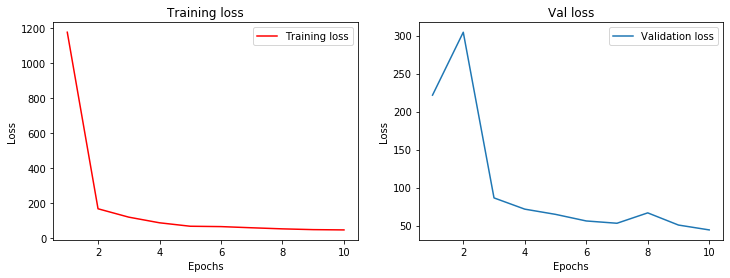

In [20]:
Epochs = np.linspace(1,number_epochs,number_epochs)
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
plt.setp(ax.flat, xlabel='Epochs', ylabel='Loss')
ax[0].set_title('Training loss')
ax[0].plot(Epochs, train_loss[0],'r',label='Training loss')
ax[0].legend()

ax[1].set_title('Val loss')
plt.plot(Epochs, val_loss[0],label='Validation loss')
ax[1].legend()
plt.savefig('Final Train and val losses of the AE')
plt.show()

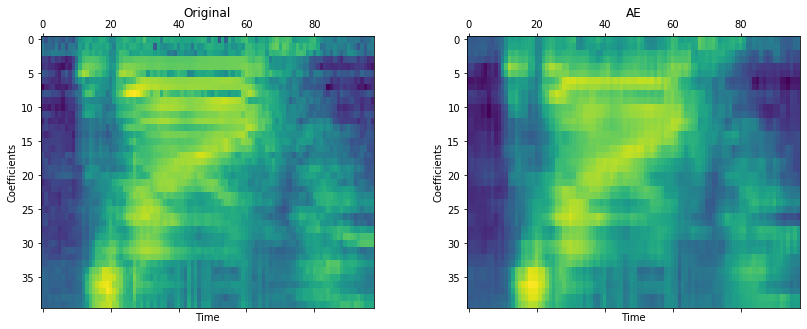

two


In [26]:
sample = np.random.randint(test_set.shape[0])
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
plt.setp(ax.flat, xlabel='Time', ylabel='Coefficients')
ax[0].set_title('Original')
ax[0].matshow(test_set[sample][:,:,0],aspect=2)

ax[1].set_title('AE')
ax[1].matshow(autoencoder.predict(test_set[sample].reshape(-1,40,98,1))[0,:,:,0],aspect=2)
plt.savefig('AE reconstruction')
plt.show()
print (words_name[np.argmax(test_labels[sample])])

In [ ]:
audio=librosa.feature.inverse.mfcc_to_audio(autoencoder.predict(training_set[10].reshape(-1,40,99,1))[0,:,:,0],200)
print (audio.shape)

In [ ]:
autoencoder.save_weights('autoencoder.h5')

In [ ]:
print (autoencoder.summary())

In [64]:
def fc(enco):
    den = BatchNormalization()(enco)
    den = Conv2D(64,(2,2),activation='relu')(den)
    den = Flatten()(den)
    den = Dense(100,activation='relu')(den)
    out = Dense(31, activation='softmax')(den)
    return out

In [65]:
layer=2
Filter=4
kernel=2
encode = encoder(input_img,layer,Filter,kernel,0)#0 dropout because now we don't 
#train the encoder of the AE part anymore
full_model = Model(input_img,fc(encode))

In [66]:
print (full_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 98, 1)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 40, 98, 6)         30        
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 40, 98, 6)         150       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 40, 98, 18)        450       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 40, 98, 18)        1314      
_________________________________________________________________
average_pooling2d_6 (Average (None, 20, 49, 18)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 49, 18)        72        
__________

In [67]:
for l1,l2 in zip(full_model.layers[:6],autoencoder.layers[:6]):
    l1.set_weights(l2.get_weights())

In [68]:
autoencoder.get_weights()[0][1]

array([[[ 0.8755315 ,  0.3271921 ,  0.40748933, -0.36564842,
         -0.06072448,  0.47860864]],

       [[ 0.35759443,  0.677824  ,  0.17179078,  0.02023051,
          0.34696653,  0.3208686 ]]], dtype=float32)

In [69]:
full_model.get_weights()[0][1]

array([[[ 0.8755315 ,  0.3271921 ,  0.40748933, -0.36564842,
         -0.06072448,  0.47860864]],

       [[ 0.35759443,  0.677824  ,  0.17179078,  0.02023051,
          0.34696653,  0.3208686 ]]], dtype=float32)

In [70]:
for layer in full_model.layers[:6]:
    layer.trainable = False

In [71]:
full_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [72]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 98, 1)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 40, 98, 6)         30        
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 40, 98, 6)         150       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 40, 98, 18)        450       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 40, 98, 18)        1314      
_________________________________________________________________
average_pooling2d_6 (Average (None, 20, 49, 18)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 49, 18)        72        
__________

In [73]:
classify_train = full_model.fit(training_set, training_labels, batch_size=512,epochs=10,
                                verbose=2,validation_data=(validation_set, validation_labels),shuffle=True)

Train on 53088 samples, validate on 7048 samples
Epoch 1/10
 - 10s - loss: 3.5863 - acc: 0.0343 - val_loss: 3.4303 - val_acc: 0.0355
Epoch 2/10
 - 8s - loss: 3.4297 - acc: 0.0377 - val_loss: 3.4271 - val_acc: 0.0355
Epoch 3/10
 - 8s - loss: 3.4280 - acc: 0.0377 - val_loss: 3.4248 - val_acc: 0.0355
Epoch 4/10
 - 8s - loss: 3.4265 - acc: 0.0377 - val_loss: 3.4234 - val_acc: 0.0355
Epoch 5/10
 - 8s - loss: 3.4260 - acc: 0.0377 - val_loss: 3.4226 - val_acc: 0.0355
Epoch 6/10
 - 8s - loss: 3.4256 - acc: 0.0377 - val_loss: 3.4220 - val_acc: 0.0355
Epoch 7/10
 - 8s - loss: 3.4254 - acc: 0.0377 - val_loss: 3.4216 - val_acc: 0.0355
Epoch 8/10
 - 8s - loss: 3.4253 - acc: 0.0377 - val_loss: 3.4214 - val_acc: 0.0355
Epoch 9/10
 - 8s - loss: 3.4253 - acc: 0.0377 - val_loss: 3.4213 - val_acc: 0.0355
Epoch 10/10
 - 8s - loss: 3.4253 - acc: 0.0377 - val_loss: 3.4211 - val_acc: 0.0355


In [ ]:
acc = classify_train.history['acc']
val_acc = classify_train.history['val_acc']
epochs = range(10)
plt.figure()
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Test set - Confusion matrix

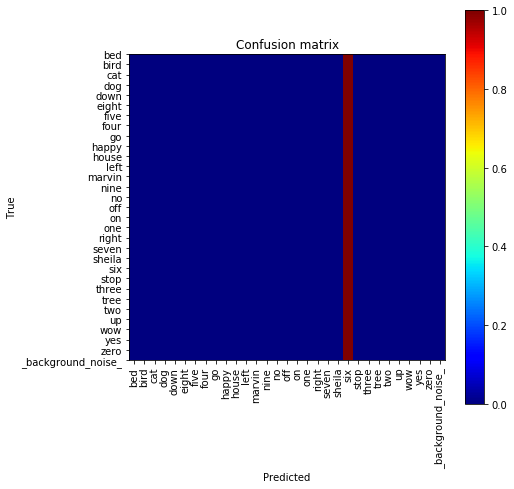

In [62]:
classifier=full_model
predictions = classifier.predict(test_set.reshape(-1,40,98,1))
new_test_labels = np.zeros(test_labels.shape[0])
for i in range(test_labels.shape[0]):
    new_test_labels[i]=np.argmax(test_labels[i])
y_pred = np.zeros(test_labels.shape[0])
for i in range(test_labels.shape[0]):
    y_pred[i]=np.argmax(predictions[i])
plot_confusion_matrix(new_test_labels,y_pred,words_name,'AE')